# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [18]:
# # ARNAU : In case you need to install the following packages, you can use the following commands:
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install tensorflow
# ! pip install pydot


In [ ]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive')


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [11]:
# # ARNAU : Trick to create `train_val` folder
# # Link to dataset publication : https://susanqq.github.io/UTKFace/
# # Steps to replicate : 
# # 1. Download the dataset from the link above (it's a zip file)
# # 2. Upload the zip folder to a `train_val` folder in your Google Drive
# # 3. Run the following code to unzip the folder

# import os
# import shutil

# # Define the root directory where subfolders are located
# root_dir = './train_val/'

# # List all the subdirectories in the root directory
# subdirs = [os.path.join(root_dir, o) for o in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,o))]

# # Loop through each subdirectory
# for subdir in subdirs:
#     # List all files in the subdirectory
#     files = os.listdir(subdir)
#     # Move each file to the root directory
#     for file in files:
#         src_path = os.path.join(subdir, file)  # Source file path
#         dst_path = os.path.join(root_dir, file)  # Destination file path
#         shutil.move(src_path, dst_path)  # Move the file
#     # After moving all files, delete the subdirectory
#     os.rmdir(subdir)


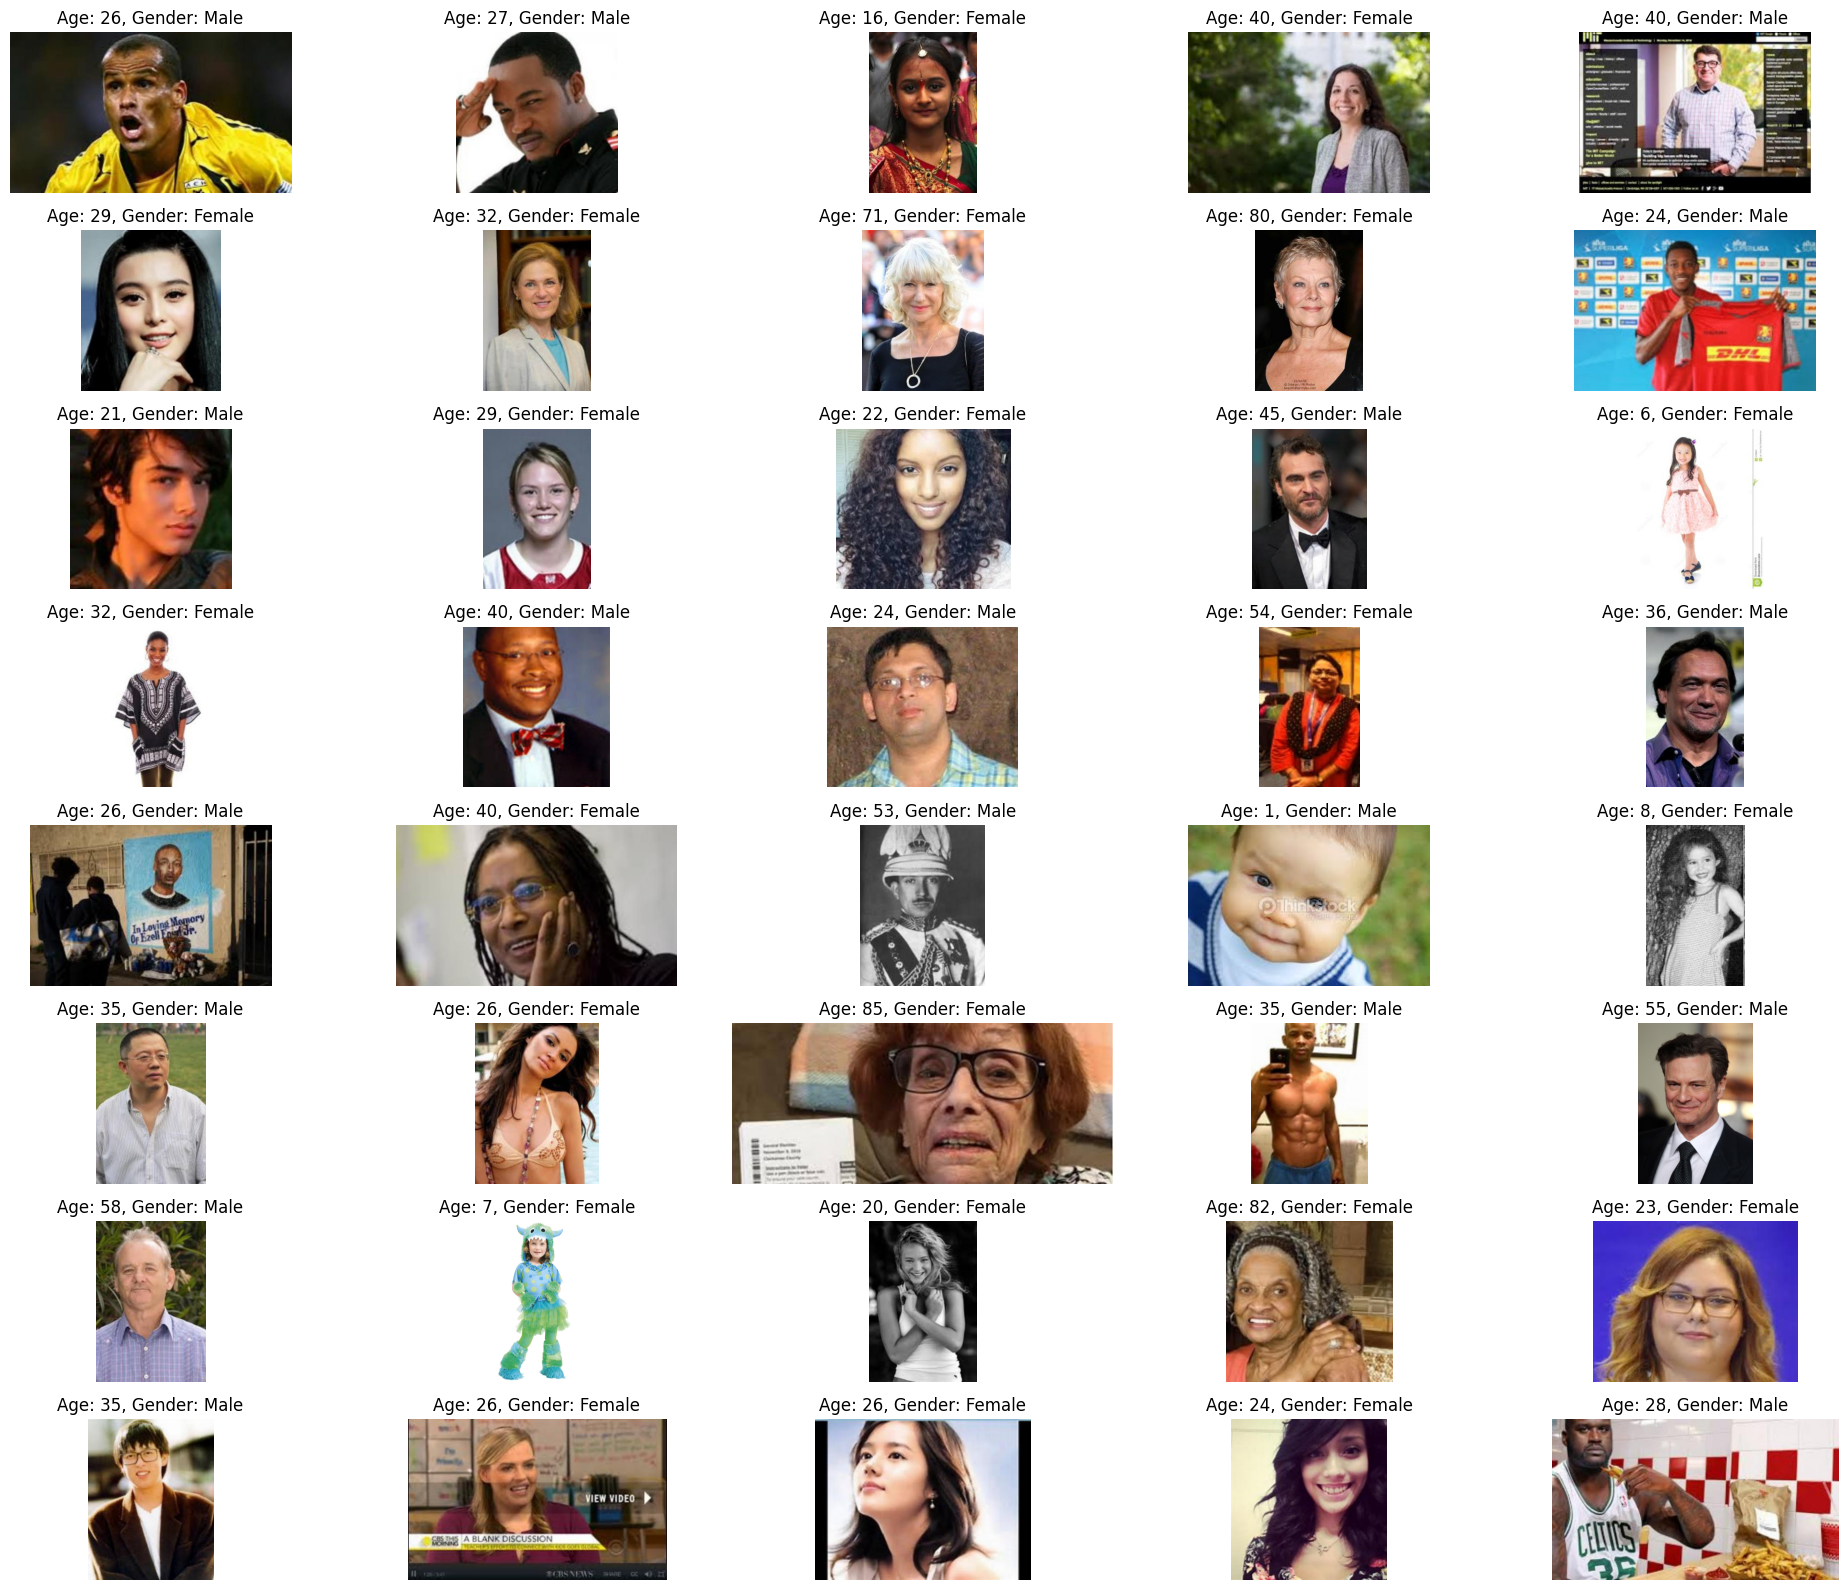

In [3]:
#
# Add your code here
#

import matplotlib.pyplot as plt
import os

# Define the directory where images are stored
image_dir = './train_val/'

# List all files in the directory
files = os.listdir(image_dir)

# Filter out 20 images for visualization
selected_files = files[:40]

# Set up the plot
fig, axes = plt.subplots(8, 5, figsize=(20, 16))
axes = axes.ravel()

for i, file_name in enumerate(selected_files):
    # Extract age and gender from the file name
    age, gender, _, _ = file_name.split('_')
    gender = 'Male' if gender == '0' else 'Female'
    
    # Load and display the image
    img = plt.imread(os.path.join(image_dir, file_name))
    axes[i].imshow(img)
    axes[i].set_title(f'Age: {age}, Gender: {gender}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [4]:
#
# Add your code here
#
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize lists to store ages, genders, and image file paths
ages = []
genders = []
image_paths = []

# Loop through each file in the selected files to extract age, gender, and file path
for file_name in files:
    # Skip system files like .DS_Store
    if file_name.startswith('.'):
        continue
    # Split the file name and check if it has the expected number of parts
    parts = file_name.split('_')
    if len(parts) >= 3:  # Ensure there are at least 3 parts (age, gender, and others)
        age, gender = parts[0], parts[1]
        # Validate age and gender to be numeric
        if age.isdigit() and gender.isdigit():
            ages.append(int(age))
            genders.append(int(gender))
            image_paths.append(os.path.join(image_dir, file_name))
        else:
            print(f"Skipping file {file_name} due to invalid age or gender value.")
    else:
        print(f"Skipping file {file_name} due to unexpected format.")


# Convert lists to numpy arrays for easier manipulation
ages = np.array(ages)
genders = np.array(genders)
image_paths = np.array(image_paths)

# Split the dataset into training and validation sets
X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42)

# Save the split data for later use
np.savez('train_val_split.npz', X_train=X_train, X_val=X_val, y_train_age=y_train_age, y_val_age=y_val_age, y_train_gender=y_train_gender, y_val_gender=y_val_gender)


Skipping file 53__0_20170116184028385.jpg due to invalid age or gender value.


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [33]:
#
# Add your code here
#

# ARNAU : Added this helper function
import tensorflow as tf

tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_and_preprocess_images(image_paths, target_size=(128, 128)):
    """
    Load images from their paths and preprocess them.
    Args:
    - image_paths: List of paths to the images.
    - target_size: Tuple specifying the image size.

    Returns:
    - A numpy array of preprocessed image data.
    """
    images = []
    for img_path in image_paths:
        # Load the image
        img = load_img(img_path, target_size=target_size)
        # Convert the image to a numpy array and rescale
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    
    return np.array(images)

# Load and preprocess the training and validation images
X_train_images = load_and_preprocess_images(X_train)
X_val_images = load_and_preprocess_images(X_val)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator for data augmentation without rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Randomly zoom inside pictures
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

# For validation data, since the images are already rescaled, no need to rescale again
validation_datagen = ImageDataGenerator()

# Stack them along a new axis to match the shape expected by flow()
y_train_combined = np.stack((y_train_age, y_train_gender), axis=1)
y_val_combined = np.stack((y_val_age, y_val_gender), axis=1)

# Now, use the combined labels with the flow() method
train_generator = train_datagen.flow(
    X_train_images,
    y_train_combined,  # Use the combined labels
    batch_size=32
)

validation_generator = validation_datagen.flow(
    X_val_images,
    y_val_combined,  # Use the combined labels
    batch_size=32
)


In [34]:
import pandas as pd
import numpy as np

# First, let's extract a single batch from the 'train_generator'.
X_batch, y_batch = next(train_generator)

# Convert the labels from the batch into a pandas DataFrame for easy viewing.
# Note: This assumes 'y_batch' is a numpy array with shape (batch_size, num_labels) where 'num_labels' is 2 in this case.
y_batch_df = pd.DataFrame(y_batch, columns=['Age', 'Gender'])

# Display the first 5 rows of the DataFrame to inspect the age and gender labels.
print("Labels DataFrame:")
print(y_batch_df.head())

# To inspect the pixel values, we'll convert the first image in the batch to a numpy array and display its shape.
# Note: This assumes 'X_batch' is a numpy array with shape (batch_size, height, width, channels).
# We'll display the shape of the first image to understand its dimensions.
print("\nFirst image in the batch shape:", X_batch[0].shape)

# Display pixel values of the first image in the batch for inspection.
# For brevity, we'll display the pixel values of a small 5x5 region from the top-left corner of the first image.
print("\nPixel values of a 5x5 region from the first image:")
print(X_batch[0][:5, :5, :])

# Calculate the maximum pixel value across the entire batch.
max_pixel_value = np.max(X_batch)
# Calculate the minimum pixel value across the entire batch.
min_pixel_value = np.min(X_batch)

# Display the calculated maximum and minimum pixel values for inspection.
print("\nMaximum pixel value in the batch:", max_pixel_value)
print("Minimum pixel value in the batch:", min_pixel_value)


Labels DataFrame:
   Age  Gender
0   26       0
1   32       0
2   21       0
3   20       0
4   18       1

First image in the batch shape: (128, 128, 3)

Pixel values of a 5x5 region from the first image:
[[[0.6403334  0.51312256 0.5418601 ]
  [0.4668765  0.34702846 0.37012774]
  [0.36355    0.25670707 0.27655506]
  [0.3042201  0.2133934  0.22697899]
  [0.3045599  0.21828537 0.23005007]]

 [[0.5063152  0.37930545 0.41701525]
  [0.35895583 0.23905413 0.2720437 ]
  [0.324762   0.21575597 0.24337518]
  [0.3051608  0.21076745 0.22863191]
  [0.306557   0.22041062 0.23243156]]

 [[0.37881774 0.25932696 0.30490658]
  [0.3180056  0.2071736  0.2495878 ]
  [0.29417825 0.19452545 0.22978431]
  [0.28080794 0.19236284 0.21826784]
  [0.2723775  0.19021825 0.20972924]]

 [[0.32230356 0.21876076 0.26863408]
  [0.31019562 0.21472248 0.25806743]
  [0.30133542 0.21460633 0.25084054]
  [0.29071018 0.20901977 0.23965809]
  [0.30114576 0.22663596 0.2424534 ]]

 [[0.32596782 0.23798624 0.2865843 ]
  [0.330

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [35]:
#
# Add your code here
#


modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

NameError: name 'modelA' is not defined

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#
# Add your code here
#

modelA.save(your_model_folder+"age_gender_A.h5")

NameError: name 'modelA' is not defined

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [ ]:
#
# Add your code here
#


## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [36]:
#
# Add your code here
#
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# Load MobileNetV2 pre-trained on ImageNet without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for your specific task
x = base_model.output

from tensorflow.keras.layers import Dropout

# Add Dropout layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x) 

# Age prediction branch
age_output = Dense(1, name='age_output')(x)  # No activation, assuming age as a regression problem

# Gender prediction branch
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Define the model with two outputs
modelB = Model(inputs=base_model.input, outputs=[age_output, gender_output])

modelB.summary()

from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

/var/folders/db/09czvxz96tdcvm__y5ys0mzm0000gn/T/ipykernel_75777/268819394.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [37]:
#
# Add your code here
#
from tensorflow.keras.optimizers import Adam

# Compile the model
modelB.compile(optimizer=Adam(learning_rate=1e-4),
               loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
               metrics={'age_output': ['mae'], 'gender_output': ['accuracy']})

# Train the model
# Note: Ensure your 'train_generator' and 'validation_generator' are correctly set up to yield the appropriate structure
# for multi-output models: ([inputs], [age_targets, gender_targets]) or
# ([inputs], {'age_output': age_targets, 'gender_output': gender_targets})
history = modelB.fit(train_generator,
                     validation_data=validation_generator,
                     epochs=10,  # Adjust based on your needs
                     verbose=1)

# Save the model
modelB.save("age_gender_B.h5")

Epoch 1/10


/opt/homebrew/anaconda3/envs/rag/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/homebrew/anaconda3/envs/rag/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/603 ━━━━━━━━━━━━━━━━━━━━ 8:33 853ms/step - age_output_mae: 16.6921 - loss: 657.2017

/opt/homebrew/anaconda3/envs/rag/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


603/603 ━━━━━━━━━━━━━━━━━━━━ 240s 397ms/step - age_output_mae: 17.1973 - loss: 590.0668 - val_age_output_mae: 18.2088 - val_loss: 469.6425
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 230s 380ms/step - age_output_mae: 17.8825 - loss: 457.4716 - val_age_output_mae: 17.7555 - val_loss: 451.6429
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 244s 404ms/step - age_output_mae: 17.6090 - loss: 444.1369 - val_age_output_mae: 17.4921 - val_loss: 443.1475
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 227s 376ms/step - age_output_mae: 17.1192 - loss: 425.2936 - val_age_output_mae: 17.3800 - val_loss: 439.1690
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 227s 375ms/step - age_output_mae: 17.1572 - loss: 429.3142 - val_age_output_mae: 17.3063 - val_loss: 436.0559
Epoch 6/10
  2/603 ━━━━━━━━━━━━━━━━━━━━ 3:30 351ms/step - age_output_mae: 17.2687 - loss: 410.4154

KeyboardInterrupt: 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#